# CS 4993 Independent Study – Machine Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData  
*Last Updated: June 8th, 2021*  

*References*
* [CS 4774 ML Material – Professor Rich Nguyen](https://www.cs.virginia.edu/~nn4pj/teaching)
* [Steps to Building Machine Learning Model](https://analyticsindiamag.com/the-7-key-steps-to-build-your-machine-learning-model/)
* [Steps to Data Preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)
* [Handling Missing Values](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
* [Feature Selection I](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
* [Feature Selection II](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [Keras Neural Network I](https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3)
* [GAN I](https://datasciencecampus.ons.gov.uk/projects/generative-adversarial-networks-gans-for-synthetic-dataset-generation-with-binary-classes/)
* [GAN II](https://nbviewer.jupyter.org/github/codyznash/GANs_for_Credit_Card_Data/blob/master/GAN_comparisons.ipynb#Generated%20Data%20Testing)

## Table of Contents <a class="anchor" id="toc"></a>
* **[0. Import Packages](#setup)**
    * [0.1 General Imports](#imp1)
    * [0.2 ML Imports](#imp2)
* **[1. Read Excel File](#data)**
    * [1.1 Data Overview](#overview)
    * [1.2 Descriptive Statistics](#stats)
    * [1.3 Inspect Null Data](#null)
* **[2. Data Preparation](#prep)**
    * [2.1 Drop Columns](#drop)
    * [2.2 Handle Categorical Variables](#handle1)
        * *[2.2.1 Manual Conversion](#manual)*
        * *[2.2.2 Encoding](#encoding)*
        * *[2.2.3 Categorical Codes](#codes)*
    * [2.3 Handle Missing Values](#handle2)
    * [2.4 Feature Scaling](#scaling)
    * [2.5 Train / Test Split](#split)
    * [2.6 Final Prepared Data](#final_data)
* **[3. Feature Selection](#feature)**
    * [3.1 Pearson Correlation](#corr)
    * [3.2 Chi-Squared Test](#chi_sq)
    * [3.3 Recursive Feature Elimination](#rfe)
    * [3.4 SelectFromModel: Lasso](#lasso)
    * [3.5 SelectFromModel: Random Forest Classifier](#rfc)
    * [3.6 Cumulative Feature Selection](#cum)
* **[4. Model Selection](#model)**
    * [4.1 Train / Test Data](#tt)
    * [4.2 Model Construction](#models)
    * [4.3 Model Evaluation Functions](#funcs)
    * [4.4 Simultaneous Model Evaluation](#eval)
    * [4.5 RandomizedSearch](#search)
* **[5. Random Data Generation](#data_gen)**
* **[6. Generative Adverserial Networks](#gan)**
    * [6.1 Network Setup](#setup2)
    * [6.2 Training GAN Models](#train)
        * [6.2.1 GAN](#gan2)
        * [6.2.2 CGAN](#cgan)
        * [6.2.3 WGAN + WCGAN](#wgan)
    * [6.3 Loss Information](#loss)
    * [6.4 Generate New Data](#new_data)
    * [6.4 Training Models on New Data](#train_gan)

## 0. Import Packages <a class="anchor" id="setup"></a>

[Table of Contents](#toc)

#### 0.1 General Imports <a class="anchor" id="imp1"></a>

In [551]:
from IPython.display import Markdown, display
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import random
import os

#### 0.2 ML Imports <a class="anchor" id="imp2"></a>

In [631]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn

from keras.layers import Dense, LeakyReLU, PReLU, BatchNormalization, Activation, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()

import xgboost as xgb
from GAN import GAN

In [553]:
tf.__version__

'2.3.0'

In [554]:
keras.__version__

'2.4.0'

In [555]:
sklearn.__version__

'0.21.2'

In [556]:
SEED = 0

## 1. Read Excel File <a class="anchor" id="data"></a>

[Table of Contents](#toc)

#### 1.1 Data Overview <a class="anchor" id="overview"></a>

In [557]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [558]:
df.shape

(7380, 41)

In [559]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

#### 1.2 Descriptive Statistics <a class="anchor" id="stats"></a>

In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [561]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [562]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [563]:
print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


In [564]:
none_detected_dups = sum(df.loc[df[target]=='None Detected'].duplicated())
detected_dups = sum(df.loc[df[target]=='Detected'].duplicated())
total_dups = none_detected_dups + detected_dups

print('None Detected Duplicates:', none_detected_dups)
print('Detected Duplicates:', detected_dups)
print('Total Duplicates:', total_dups)
print('Fraction Duplicated:', total_dups / len(df))

None Detected Duplicates: 0
Detected Duplicates: 0
Total Duplicates: 0
Fraction Duplicated: 0.0


#### 1.3 Inspect Null Data <a class="anchor" id="null"></a>

In [565]:
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [566]:
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

print("Null Data Points by variable")
d

Null Data Points by variable


{'height': 93.8211,
 'AdmittingDepartment': 59.3089,
 'wght': 55.9892,
 'cbc_eosinophil_perc': 47.5339,
 'cbc_eosinophil_c': 47.5339,
 'cbc_eosinophil_perc.1': 47.5339,
 'cbc_eosinophil_perc.2': 47.5339,
 'cbc_neutrophil_c': 47.5203,
 'cbc_lymphocyte_c': 47.5068,
 'cbc_lymphocyte_perc': 47.5068,
 'cbc_monocyte_c': 47.5068,
 'cmp_ast': 35.4065,
 'cmp_total_protein': 29.878,
 'cmp_alkaline_phosphatase': 26.8428,
 'cmp_alt': 26.8157,
 'cmp_bilirubin': 26.8157,
 'cmp_albumin': 26.8022,
 'cmp_potassium': 24.5257,
 'cbc_wbc': 15.2304,
 'cbc_hematocrit': 15.2304,
 'cbc_platelets': 15.2304,
 'cbc_hemoglobin': 15.2168,
 'cmp_bicarbonate': 14.9593,
 'cmp_sodium': 14.8238,
 'cmp_chloride': 14.8238,
 'cmp_bun': 14.8238,
 'cmp_creatinine': 14.8238,
 'cmp_glucose': 14.8238,
 'sbp': 1.1924,
 'dbp': 1.1924,
 'resp_rate': 0.9214,
 'pulse_ox': 0.4607,
 'heart_rate': 0.3794,
 'FirstRace': 0.0136,
 'index': 0.0,
 'patno': 0.0,
 'Admitted': 0.0,
 'COVIDResult': 0.0,
 'Age': 0.0,
 'Ethnicity': 0.0,
 'Sex': 

<AxesSubplot:>

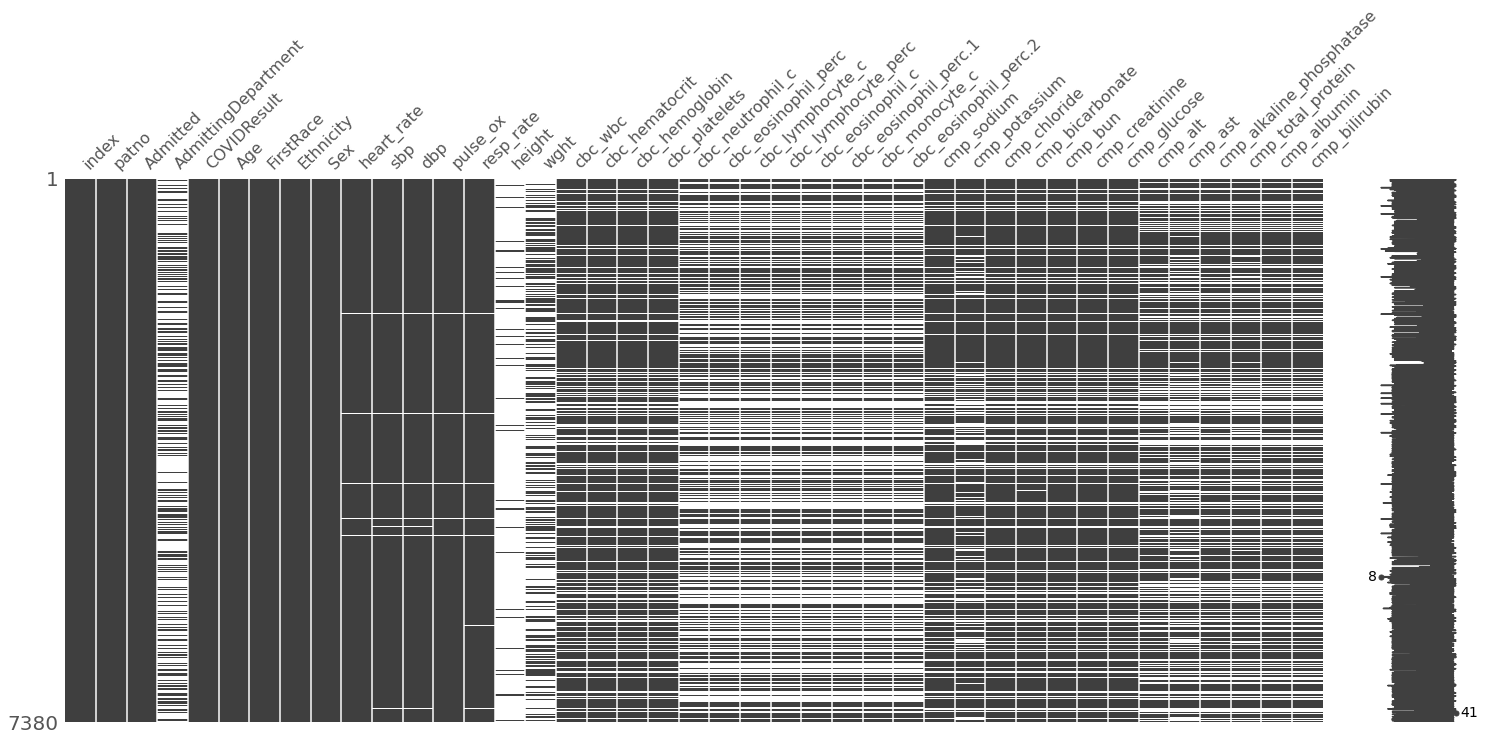

In [567]:
msno.matrix(df)
# msno.heatmap(df)

## 2. Data Preparation <a class="anchor" id="prep"></a>

[Table of Contents](#toc)

#### 2.1 Drop Columns <a class="anchor" id="drop"></a>

In [568]:
drop = False

In [569]:
if drop:
    trim_df = df.drop(columns=majority_null)
    trim_df = trim_df.drop(columns=['index', 'patno'])
    trim_df.head(5)
else:
    trim_df = df

In [570]:
trim_df.isnull().sum().sum()

69411

#### 2.2 Handle Categorical Variables <a class="anchor" id="handle1"></a>

In [571]:
trim_df.select_dtypes(include=['object']).columns

Index(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt',
       'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion <a class="anchor" id="manual"></a>

In [572]:
num_cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(num_cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

trim_df2.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [573]:
trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

###### 2.2.2 Encoding <a class="anchor" id="encoding"></a>

In [574]:
cat_cols = list(trim_df2.select_dtypes(include=['object']).columns)

trim_df3 = trim_df2.copy()
trim_df3['FirstRace'] = trim_df3['FirstRace'].fillna("Unspecified")
if not drop:
    trim_df3['AdmittingDepartment'] = trim_df3['AdmittingDepartment'].fillna('N/A')
for col in cat_cols:
    enc = OrdinalEncoder()
    y = enc.fit_transform(trim_df3[[col]])
    if col == 'COVIDResult':
        y = 1 - y
    trim_df3[col + "_Encoded"] = y
trim_df3.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,N/A,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,N/A,None Detected,55,African American,Non-Hispanic,Male,83.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,N/A,None Detected,67,African American,Non-Hispanic,Female,90.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


###### 2.2.3 Categorical Codes <a class="anchor" id="codes"></a>

In [575]:
for col in cat_cols:
    if col == 'AdmittingDepartment':
        continue
    display(Markdown("**{}**".format(col)))
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

**COVIDResult**

('Detected', 1.0)
('None Detected', 0.0)



**FirstRace**

('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)



**Ethnicity**

('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)



**Sex**

('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [576]:
trim_df3 = trim_df3.drop(columns=cat_cols)
trim_df3.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,NaN,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,NaN,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,NaN,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,NaN,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,NaN,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [577]:
trim_df3.shape

(7380, 41)

In [578]:
trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        7380 non-null   int64  
 1   patno                        7380 non-null   int64  
 2   Admitted                     7380 non-null   int64  
 3   Age                          7380 non-null   int64  
 4   heart_rate                   7352 non-null   float64
 5   sbp                          7292 non-null   float64
 6   dbp                          7292 non-null   float64
 7   pulse_ox                     7346 non-null   float64
 8   resp_rate                    7312 non-null   float64
 9   height                       456 non-null    float64
 10  wght                         3248 non-null   float64
 11  cbc_wbc                      6256 non-null   float64
 12  cbc_hematocrit               6256 non-null   float64
 13  cbc_hemoglobin    

#### 2.3 Handle Missing Values <a class="anchor" id="handle2"></a>

In [579]:
fill_option = 'A'

In [580]:
num_cols = list(trim_df2.select_dtypes(include=['float64']).columns)

trim_df4 = trim_df3.copy()
for col in num_cols:
    if fill_option == 'A':
        trim_df4[col] = trim_df4[col].fillna(0)
    else:
        trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
trim_df4.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,0.0,...,0.0,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,0.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,0.0,...,0.0,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,0.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [581]:
trim_df3.isnull().sum().sum()

65033

In [582]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling <a class="anchor" id="scaling"></a>

In [583]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded',
    'AdmittingDepartment_Encoded', 'COVIDResult_Encoded'
]

if drop:
    code_cols.remove('AdmittingDepartment_Encoded')

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [584]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
merged_df.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.731816,-1.731816,1.233730,-0.007125,0.117440,0.397106,-0.081200,1.162329,-0.254819,-0.760847,...,-0.038140,1.020349,0.837005,-0.077854,1,9.0,2.0,0.0,30.0,0.0
1,-1.731347,-1.731347,-1.104301,1.116931,-0.012210,0.743825,0.181805,-0.403647,-0.254819,-0.760847,...,0.179028,0.901837,1.006128,-0.012027,0,9.0,2.0,0.0,1.0,0.0
2,-1.730877,-1.730877,0.256008,-0.465074,0.571215,0.050387,0.181805,0.023438,-0.254819,1.151812,...,0.244178,0.605558,0.667883,0.053800,0,0.0,2.0,1.0,1.0,0.0
3,-1.730408,-1.730408,0.043460,-0.256915,0.117440,-0.585264,-1.264722,-0.403647,-0.254819,-0.760847,...,-0.059856,0.812953,0.498760,-0.077854,1,9.0,2.0,1.0,30.0,0.0
4,-1.729939,-1.729939,0.766124,-0.173652,-0.206684,-0.354118,0.181805,-0.403647,-0.254819,-0.760847,...,0.417912,0.694442,0.386011,-0.275334,0,0.0,2.0,0.0,1.0,0.0


#### 2.5 Train / Test Split <a class="anchor" id="split"></a>

In [585]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)

#### 2.6 Final Prepared Data <a class="anchor" id="final_data"></a>

In [586]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [587]:
final_data.shape

(7380, 41)

In [588]:
final_train.shape

(5904, 41)

In [589]:
final_test.shape

(1476, 41)

In [488]:
print(final_train[target].value_counts())
print(final_test[target].value_counts())

0.0    5526
1.0     378
Name: COVIDResult_Encoded, dtype: int64
0.0    1384
1.0      92
Name: COVIDResult_Encoded, dtype: int64


## 3. Feature Selection <a class="anchor" id="feature"></a>

[Table of Contents](#toc)

In [489]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]

###### Number of Features

In [490]:
top_n_feats = len(X.columns)

In [491]:
def plot_scores(scores, selector):
    plt.bar(range(len(scores)), scores, color='b')
    plt.show()

#### 3.1 Pearson Correlation <a class="anchor" id="corr"></a>

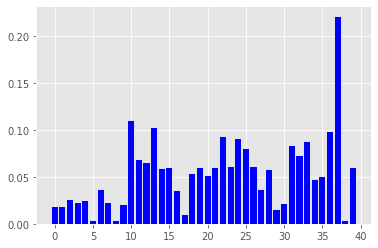

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [492]:
def correlation_selector(x, y):
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    plot_scores(list(correl_dict.values()), 'correlation')
    
    correl_dict = dict(sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats])
    top_n = np.array([
        True if col in list(correl_dict.keys()) else False for col in x.columns.tolist()
    ])
    return top_n


corr_top_n = correlation_selector(X, Y)
corr_top_n

#### 3.2 Chi-Squared <a class="anchor" id="chi_sq"></a>

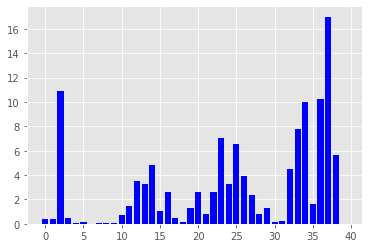

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [493]:
def chi_selector(y):
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    plot_scores(chi_sq.scores_, 'chi-squared')
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

#### 3.3 Recursive Feature Elimination <a class="anchor" id="rfe"></a>

In [494]:
def rfe_selector(y):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=top_n_feats, step=10, verbose=0)
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### 3.4 Lasso: SelectFromModel <a class="anchor" id="lasso"></a>

In [495]:
def lasso_selector(y):
    lasso = SelectFromModel(LogisticRegression(penalty="l2"), max_features=top_n_feats)
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([False, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel <a class="anchor" id="rfc"></a>

In [496]:
def rfc_selector(x, y):
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True])

#### 3.6 Cumulative Feature Selection <a class="anchor" id="cum"></a>

In [497]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,heart_rate,True,True,True,True,True,5
2,cbc_platelets,True,True,True,True,True,5
3,Ethnicity_Encoded,True,True,True,True,True,5
4,wght,True,True,True,False,True,4
5,sbp,True,True,True,False,True,4
6,resp_rate,True,True,True,False,True,4
7,pulse_ox,True,True,True,False,True,4
8,patno,True,True,True,False,True,4
9,index,True,True,True,False,True,4
10,dbp,True,True,True,False,True,4


In [498]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['heart_rate',
 'cbc_platelets',
 'Ethnicity_Encoded',
 'wght',
 'sbp',
 'resp_rate',
 'pulse_ox',
 'patno',
 'index',
 'dbp',
 'cmp_total_protein',
 'cmp_sodium',
 'cmp_bilirubin',
 'cbc_wbc',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_lymphocyte_perc',
 'cbc_lymphocyte_c',
 'cbc_hematocrit',
 'cbc_eosinophil_c',
 'Sex_Encoded',
 'Age',
 'AdmittingDepartment_Encoded',
 'Admitted',
 'height',
 'cmp_potassium',
 'cmp_glucose',
 'cmp_creatinine',
 'cmp_chloride',
 'cmp_bun',
 'cmp_bicarbonate',
 'cmp_ast',
 'cmp_alt',
 'cmp_alkaline_phosphatase',
 'cmp_albumin',
 'cbc_hemoglobin',
 'cbc_eosinophil_perc.2',
 'cbc_eosinophil_perc.1',
 'cbc_eosinophil_perc',
 'FirstRace_Encoded']

## 4. Model Selection <a class="anchor" id="model"></a>

[Table of Contents](#toc)

#### 4.1 Train / Test Data <a class="anchor" id="tt"></a>

In [499]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [500]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 40)
y_train (5904,)

X_test (1476, 40)
y_test (1476,)


#### 4.2 Model Construction <a class="anchor" id="models"></a>

[Keras Layers/Activation Documentation](https://keras.io/api/layers/)

Loss Functions
* 'binary_crossentropy'
* 'sparse_categorical_crossentropy'

Optimizers
* 'adam'
* 'sgd'

In [501]:
tf.keras.backend.set_floatx('float64')
tf.set_random_seed(SEED)
np.random.seed(SEED)

In [502]:
seq1 = Sequential([
    BatchNormalization(),
    Dense(300, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dense(100, use_bias=False),
    Activation('relu'),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [503]:
seq2 = Sequential([
    Dense(top_n_feats, activation='relu'),
    Dense(6, activation='relu'),
    Dense(2, activation='softmax')
])

In [504]:
seq3 = Sequential([
    Dense(top_n_feats, kernel_initializer='he_normal'),
    PReLU(),
    Dense(6, kernel_initializer='he_normal'),
    PReLU(),
    Dense(2, activation='softmax')
])

In [505]:
# keras.utils.plot_model(model, "seq_model1.png", show_shapes=True)

#### 4.3 Model Evaluation Functions <a class="anchor" id="funcs"></a>

In [506]:
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [507]:
def plot_history(hist):
    display(Markdown('**Training/Validation Loss and Accuracy**'))
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [656]:
def metric_evaluation(y_test, y_pred):
    display(Markdown('**Metric Scores**'))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    display(Markdown('**Confusion Matrix**'))
    print(confusion_matrix(y_test, y_pred))

In [657]:
def plot_confusion_matrix(y_test, y_pred, labels=['None Detected', 'Detected']):
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), columns=labels, index=labels
    )
    ax = sns.heatmap(
        data=cm_df, cmap=cm.Blues, annot=True, fmt='d'
    )
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

#### 4.4 Simultaneous Model Evaluation <a class="anchor" id="eval"></a>

In [510]:
model_lst = [
    {'name': 'Sequential: Dense + Batch Normalization Layers, ReLU Activations',
     'model': seq1, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)},
    {'name': 'Sequential: Dense Layers, ReLU Activation',
     'model': seq2, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)},
    {'name': 'Sequential: Dense Layers, PReLU Activation',
     'model': seq3, 'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-4)}
]

In [511]:
EPOCHS = 30
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [512]:
X_train

,heart_rate,cbc_platelets,Ethnicity_Encoded,wght,sbp,resp_rate,pulse_ox,patno,index,dbp,...,cmp_bicarbonate,cmp_ast,cmp_alt,cmp_alkaline_phosphatase,cmp_albumin,cbc_hemoglobin,cbc_eosinophil_perc.2,cbc_eosinophil_perc.1,cbc_eosinophil_perc,FirstRace_Encoded
4271,-0.756495,-0.196337,2.0,-0.760847,0.862927,-0.688369,-0.081200,0.272951,0.272951,0.801611,...,0.799936,0.047894,0.116149,-0.168440,1.231625,0.923203,0.948847,0.948847,0.948847,9.0
1095,-0.465074,-0.211818,2.0,0.807753,1.251877,-0.403647,-0.081200,-1.217834,-1.217834,0.339319,...,0.361363,0.040001,-0.001183,-0.027281,1.006128,1.219566,1.280428,1.280428,1.280428,9.0
3538,0.409192,-1.605049,2.0,-0.760847,-0.336334,-0.688369,0.313307,-0.071113,-0.071113,-0.758624,...,-2.160435,-0.283608,-0.222043,-0.906810,-1.587089,-2.119453,-0.432740,-0.432740,-0.432740,9.0
2377,-0.423442,-0.823291,2.0,1.424864,-0.498397,-0.403647,-0.081200,-0.616075,-0.616075,-0.469691,...,0.361363,14.144633,16.887664,0.852247,0.216888,0.686113,1.777799,1.777799,1.777799,9.0
3414,0.076139,0.353215,2.0,1.220236,-0.206684,1.019967,-0.344205,-0.129317,-0.129317,-0.874197,...,0.142076,-0.086285,-0.153024,-0.103290,0.386011,0.646598,-0.432740,-0.432740,-0.432740,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,-1.131181,0.337735,2.0,-0.760847,-0.303922,-0.688369,0.313307,0.582748,0.582748,0.281533,...,0.580649,-0.109964,-0.084005,-0.320458,1.118877,0.942960,1.225165,1.225165,1.225165,9.0
3264,-0.132020,0.980169,2.0,1.098234,-0.174272,-0.118924,0.313307,-0.199726,-0.199726,0.165960,...,0.471006,-0.086285,-0.090907,0.005294,0.780631,0.765143,-0.432740,-0.432740,-0.432740,9.0
1653,-0.506705,-0.885213,2.0,1.044656,-0.174272,-0.261285,0.444810,-0.955914,-0.955914,-0.874197,...,0.690293,-0.086285,-0.222043,-0.222732,0.329637,-0.538853,-0.432740,-0.432740,-0.432740,0.0
2607,2.074460,0.345475,2.0,-0.760847,0.214678,-0.118924,0.181805,-0.508115,-0.508115,0.281533,...,0.471006,-0.062606,-0.070202,-0.081573,1.062503,0.824415,-0.432740,-0.432740,-0.432740,9.0


In [513]:
def test_models(models, xy, isolate=None):
    X_train, y_train, X_test, y_test = xy
    X_train = np.array(X_train.values.tolist())
    y_train = np.array(y_train)
    for i, m in enumerate(models):
        name, model, loss, optimizer = m.values()
        if isolate is not None and i + 1 != isolate:
            print('Skipping Model {}...'.format(i + 1))
            continue
        
        display(Markdown('### Model {} – {}'.format(i + 1, name)))
        
        # 1. Compile
        model.compile(
            loss=loss, optimizer=optimizer, metrics=['accuracy']
        )
        
        # 2. Fit
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
        )
        
        # 3. Visualize Model
        display(Markdown("**Summary**"))
        model.summary()
        plot_history(history)
        
        # 4. Evaluate
        display(Markdown("**Evaluation and Prediction**"))
        loss, accuracy = model.evaluate(x=X_test, y=y_test)
        print("\nLoss: {:.2f}%".format(loss * 100))
        print("Accuracy: {:.2f}%".format(accuracy * 100))
        
        # 5. Predict
        y_prediction_array = model.predict(X_test)
        y_prediction = np.argmax(y_prediction_array, axis=1)
        
        # 6. Visualize Predictions
        metric_evaluation(y_test, y_prediction)
        
        print()

### Model 1 – Sequential: Dense + Batch Normalization Layers, ReLU Activations

**Summary**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch multiple                  160       
_________________________________________________________________
dense_114 (Dense)            multiple                  12000     
_________________________________________________________________
batch_normalization_7 (Batch multiple                  1200      
_________________________________________________________________
activation_4 (Activation)    multiple                  0         
_________________________________________________________________
dense_115 (Dense)            multiple                  30000     
_________________________________________________________________
activation_5 (Activation)    multiple                  0         
_________________________________________________________________
batch_normalization_8 (Batch multiple                 

**Training/Validation Loss and Accuracy**

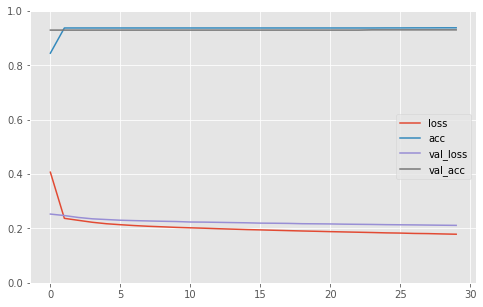

**Evaluation and Prediction**


Loss: 19.31%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%

Confusion Matrix:
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

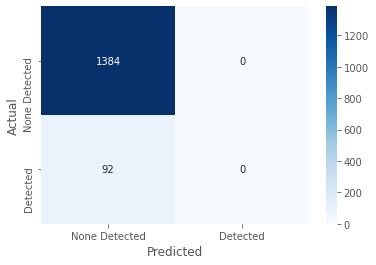

### Model 2 – Sequential: Dense Layers, ReLU Activation

**Summary**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            multiple                  1640      
_________________________________________________________________
dense_118 (Dense)            multiple                  246       
_________________________________________________________________
dense_119 (Dense)            multiple                  14        
Total params: 1,900
Trainable params: 1,900
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

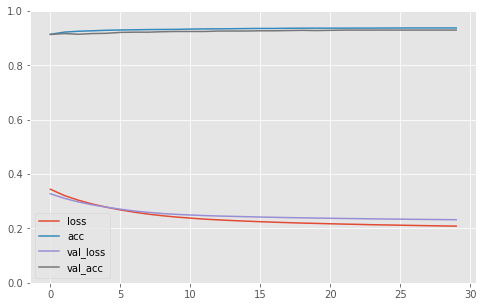

**Evaluation and Prediction**


Loss: 20.46%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%

Confusion Matrix:
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

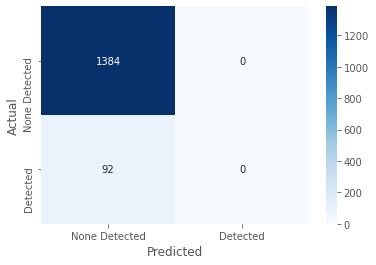

### Model 3 – Sequential: Dense Layers, PReLU Activation

**Summary**

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            multiple                  1640      
_________________________________________________________________
p_re_lu_4 (PReLU)            multiple                  40        
_________________________________________________________________
dense_121 (Dense)            multiple                  246       
_________________________________________________________________
p_re_lu_5 (PReLU)            multiple                  6         
_________________________________________________________________
dense_122 (Dense)            multiple                  14        
Total params: 1,946
Trainable params: 1,946
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

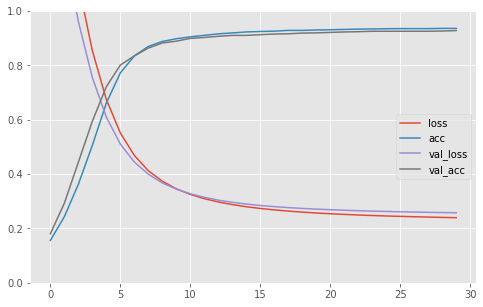

**Evaluation and Prediction**


Loss: 22.93%
Accuracy: 93.56%


**Metric Scores**

Accuracy: 93.56%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%

Confusion Matrix:
[[1381    3]
 [  92    0]]


**Confusion Matrix**

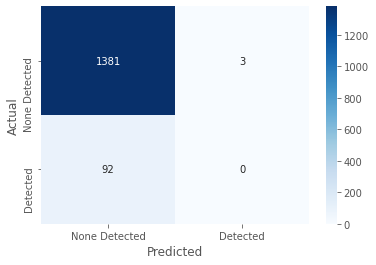

In [514]:
test_models(model_lst, (X_train, y_train, X_test, y_test))

#### 4.5 Randomized Search <a class="anchor" id="search"></a>

In [127]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[top_n_feats]):
    model = Sequential([
        InputLayer(input_shape=input_shape)
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [128]:
keras_reg = KerasRegressor(build_model)

In [129]:
hyperparameters = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

In [130]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [131]:
rnd_search_cv = RandomizedSearchCV(keras_reg, hyperparameters, n_iter=10, cv=cv)

In [132]:
%%time
rnd_search_cv.fit(
    X_train, y_train, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[EarlyStopping(patience=10)], verbose=0
)

19/19 [==============================] - 0s 865us/step - loss: 0.0967


19/19 [==============================] - 0s 830us/step - loss: 0.0606


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 27min 32s, sys: 3min 43s, total: 31min 16s
Wall time: 20min 29s


RandomizedSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x14e33d3c8>,
                   error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1504cc518>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1550...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [133]:
best_params = rnd_search_cv.best_params_
best_params

{'learning_rate': 0.02298924804076755, 'n_hidden': 1, 'n_neurons': 9}

In [134]:
rnd_search_cv.best_score_

-0.05697540660862684

In [135]:
cv_results = pd.DataFrame(rnd_search_cv.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_hidden,param_n_neurons,params,split0_test_score,split1_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,5.258703,0.336717,0.077058,0.007565,0.000371923,3,80,"{'learning_rate': 0.00037192261022352417, 'n_h...",-0.074291,-0.072709,...,-0.073655,-0.070190,-0.069607,-0.073730,-0.067097,-0.072376,-0.092841,-0.077742,0.009601,7
1,3.852280,0.108896,0.072829,0.002893,0.000876322,1,47,"{'learning_rate': 0.0008763224455697141, 'n_hi...",-0.077177,-0.090914,...,-0.081447,-0.083505,-0.074744,-0.077163,-0.076992,-0.077082,-0.082367,-0.085049,0.007835,8
2,4.578925,0.112232,0.088715,0.073961,0.0051748,3,55,"{'learning_rate': 0.0051747964719537, 'n_hidde...",-0.056566,-0.055925,...,-0.062680,-0.054774,-0.059033,-0.054272,-0.054456,-0.054698,-0.064320,-0.058105,0.004558,3
3,1.398059,0.015037,0.086876,0.076467,0.0277705,0,3,"{'learning_rate': 0.027770456976200626, 'n_hid...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,3.969833,0.120470,0.075540,0.009133,0.0157399,2,21,"{'learning_rate': 0.01573990360087585, 'n_hidd...",-0.054962,-0.055206,...,-0.058380,-0.059654,-0.056241,-0.055545,-0.053425,-0.052626,-0.059286,-0.057533,0.004244,2


In [136]:
cv_results.iloc[rnd_search_cv.best_index_]

mean_fit_time                                                    3.86284
std_fit_time                                                    0.391776
mean_score_time                                                0.0774776
std_score_time                                                 0.0176452
param_learning_rate                                            0.0229892
param_n_hidden                                                         1
param_n_neurons                                                        9
params                 {'learning_rate': 0.02298924804076755, 'n_hidd...
split0_test_score                                             -0.0563913
split1_test_score                                             -0.0557954
split2_test_score                                             -0.0562857
split3_test_score                                              -0.058103
split4_test_score                                             -0.0575592
split5_test_score                                  

In [137]:
top_x = 3

In [138]:
top_x_models = cv_results.loc[cv_results['rank_test_score'].isin(range(1, top_x+1))].sort_values(by=['rank_test_score'])
final_top_x_models = top_x_models.reset_index()
final_top_x_models

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_hidden,param_n_neurons,params,split0_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,6,3.862837,0.391776,0.077478,0.017645,0.0229892,1,9,"{'learning_rate': 0.02298924804076755, 'n_hidd...",-0.056391,...,-0.058774,-0.057345,-0.055770,-0.057085,-0.054720,-0.056655,-0.058430,-0.056975,0.001754,1
1,4,3.969833,0.120470,0.075540,0.009133,0.0157399,2,21,"{'learning_rate': 0.01573990360087585, 'n_hidd...",-0.054962,...,-0.058380,-0.059654,-0.056241,-0.055545,-0.053425,-0.052626,-0.059286,-0.057533,0.004244,2
2,2,4.578925,0.112232,0.088715,0.073961,0.0051748,3,55,"{'learning_rate': 0.0051747964719537, 'n_hidde...",-0.056566,...,-0.062680,-0.054774,-0.059033,-0.054272,-0.054456,-0.054698,-0.064320,-0.058105,0.004558,3


In [139]:
def build_model2(n_hidden, n_neurons):
    model = Sequential([
        InputLayer(input_shape=[top_n_feats])
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    return model

In [140]:
best_models_list = [{
    'name': 'Randomized Search: #{} Model'.format(idx + 1),
    'model': build_model2(n_hidden=model['param_n_hidden'], n_neurons=model['param_n_neurons']),
    'loss': 'sparse_categorical_crossentropy',
    'optimizer': SGD(learning_rate=model['param_learning_rate'])
} for idx, model in final_top_x_models.iterrows()]

In [141]:
best_models_list

[{'name': 'Randomized Search: #1 Model',
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x15b2ee6a0>,
  'loss': 'sparse_categorical_crossentropy',
  'optimizer': <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD at 0x15876fe80>},
 {'name': 'Randomized Search: #2 Model',
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x15875e668>,
  'loss': 'sparse_categorical_crossentropy',
  'optimizer': <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD at 0x15876c1d0>},
 {'name': 'Randomized Search: #3 Model',
  'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x15876cdd8>,
  'loss': 'sparse_categorical_crossentropy',
  'optimizer': <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD at 0x15f9244e0>}]

In [143]:
# test_models(best_models_list, (X_train, y_train, X_test, y_test))

## 5. Random Data Generation <a class="anchor" id="data_gen"></a>

[Table of Contents](#toc)

In [ ]:
new_data_points = 7500

In [ ]:
new_data = pd.DataFrame()

In [ ]:
%%time

total = len(trim_df4)
for col in trim_df4.columns.tolist():
    if col in code_cols:
        counts = trim_df4[col].value_counts()
        choices = list(counts.index)
        weights = [count/total for count in counts.values]
        new_data[col] = np.random.choice(
            a=choices, p=weights, size=(new_data_points,)
        )
    else:
        new_data[col] = np.random.normal(
            loc=trim_df4[col].mean(), scale=trim_df4[col].std(), size=new_data_points
        )

In [ ]:
new_data.head(5)

In [ ]:
new_data.shape

In [ ]:
real = trim_df4.describe()
fake = new_data.describe()
fake

In [ ]:
mean_real = real.iloc[1]
mean_fake = fake.iloc[1]
std_real = real.iloc[2]
std_fake = fake.iloc[2]

In [ ]:
(mean_real - mean_fake).mean()

In [ ]:
(std_real - std_fake).mean()

In [ ]:
new_df = pd.concat([trim_df4, new_data], axis=0).reset_index().drop(columns=['index'])

In [ ]:
new_df.head(5)

In [ ]:
new_df.shape

In [ ]:
codes_df2 = new_df[code_cols]
trim_df6 = new_df.drop(columns=code_cols)
scaler2 = StandardScaler()
scaled_df2 = pd.DataFrame(data=scaler2.fit_transform(trim_df6), columns=trim_df6.columns.tolist())
merged_df2 = pd.concat([scaled_df2, codes_df2], axis=1)
merged_df2.head()

In [ ]:
train2, test2 = train_test_split(merged_df2, test_size=0.2, random_state=SEED)

In [ ]:
final_data2 = merged_df2.copy()
final_train2 = train2.copy()
final_test2 = test2.copy()
target = 'COVIDResult_Encoded'

In [ ]:
print(final_train2[target].value_counts())
print(final_test2[target].value_counts())

In [ ]:
X_train2 = final_train2.loc[:, final_train2.columns != target]
y_train2 = final_train2[target]

X_test2 = final_test2.loc[:, final_test2.columns != target]
y_test2 = final_test2[target]

In [ ]:
test_models(model_lst, (X_train2, y_train2, X_test2, y_test2))

## 6. Generative Adverserial Networks (GAN) <a class="anchor" id="gan"></a>

[Table of Contents](#toc)

#### 6.1 Network Setup <a class="anchor" id="setup2"></a>

In [598]:
RAND_DIM = 32
NB_STEPS = 500 + 1
BASE_N_COUNT = 128
BATCH_SIZE = 128
NUM_UPDATES_D = 1         # number of critic network updates per adversarial training step
NUM_UPDATES_G = 1         # number of generator network updates per adversarial training step
NUM_PRE_TRAIN_STEPS = 100 # number of steps to pre-train the critic before starting adversarial training
LOG_INTERVAL = 100        # interval (in steps) at which to log loss summaries and save plots of image samples to disc
LEARNING_RATE = 5e-4 
DIRECTORY = 'GAN/outputs/'
SHOW = True
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

arguments = [
    RAND_DIM, NB_STEPS, BATCH_SIZE, NUM_UPDATES_D, NUM_UPDATES_G, NUM_PRE_TRAIN_STEPS, LOG_INTERVAL,
    LEARNING_RATE, BASE_N_COUNT, DIRECTORY, generator_model_path, discriminator_model_path, loss_pickle_path, SHOW
]

In [662]:
target = 'COVIDResult_Encoded'
# all_detected = final_data.loc[final_data[target] == 1]
# all_detected.head()
# train = all_detected.copy().reset_index(drop=True)
train = final_data.copy()

In [663]:
all_columns = list(train.columns.tolist())
data_cols = all_columns[:-1]
label_cols = [target]
train_no_label = train[data_cols] / 10

In [664]:
train.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.731816,-1.731816,1.233730,-0.007125,0.117440,0.397106,-0.081200,1.162329,-0.254819,-0.760847,...,-0.038140,1.020349,0.837005,-0.077854,1,9.0,2.0,0.0,30.0,0.0
1,-1.731347,-1.731347,-1.104301,1.116931,-0.012210,0.743825,0.181805,-0.403647,-0.254819,-0.760847,...,0.179028,0.901837,1.006128,-0.012027,0,9.0,2.0,0.0,1.0,0.0
2,-1.730877,-1.730877,0.256008,-0.465074,0.571215,0.050387,0.181805,0.023438,-0.254819,1.151812,...,0.244178,0.605558,0.667883,0.053800,0,0.0,2.0,1.0,1.0,0.0
3,-1.730408,-1.730408,0.043460,-0.256915,0.117440,-0.585264,-1.264722,-0.403647,-0.254819,-0.760847,...,-0.059856,0.812953,0.498760,-0.077854,1,9.0,2.0,1.0,30.0,0.0
4,-1.729939,-1.729939,0.766124,-0.173652,-0.206684,-0.354118,0.181805,-0.403647,-0.254819,-0.760847,...,0.417912,0.694442,0.386011,-0.275334,0,0.0,2.0,0.0,1.0,0.0


#### 6.2 Train GAN Models <a class="anchor" id="train"></a>

###### 6.2.1 GAN <a class="anchor" id="gan2"></a>

data_dim:  40
data_cols:  ['index', 'patno', 'Age', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin', 'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'AdmittingDepartment_Encoded']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_203 (Dense)            (None, 128)   

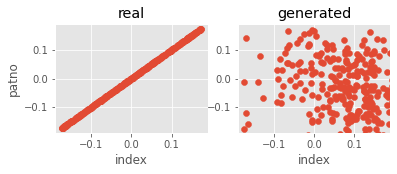

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8546, 0.7731, 0.7095, 1.0000
D Real - D Gen: -0.0637


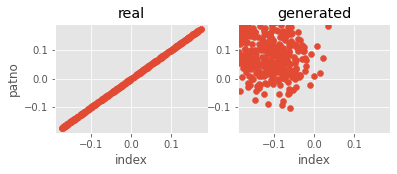

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2695, 0.5956, 0.6055, 1.0000
D Real - D Gen: 0.0099


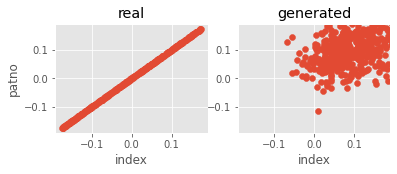

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4161, 0.3859, 0.3965, 1.0000
D Real - D Gen: 0.0106


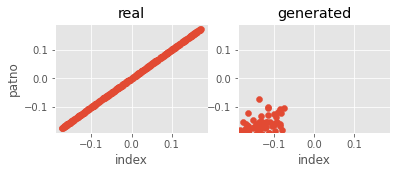

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1043, 0.6666, 0.8006, 0.9872
D Real - D Gen: 0.1340


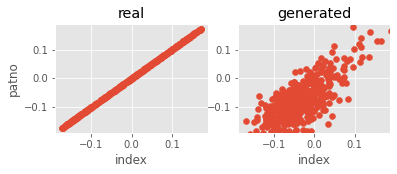

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9468, 0.6129, 0.6689, 0.9936
D Real - D Gen: 0.0560


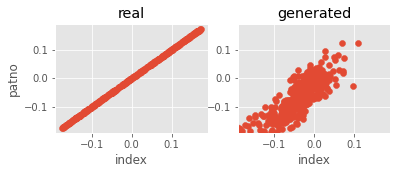

CPU times: user 1min 20s, sys: 4.37 s, total: 1min 24s
Wall time: 39 s


In [665]:
%%time
# GAN
GAN.adversarial_training_GAN(
    arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
)

###### 6.2.2 CGAN <a class="anchor" id="cgan"></a>

data_dim:  40
data_cols:  ['index', 'patno', 'Age', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin', 'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'AdmittingDepartment_Encoded']
label_dim:  1
label_cols:  ['COVIDResult_Encoded']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 32)]         0    

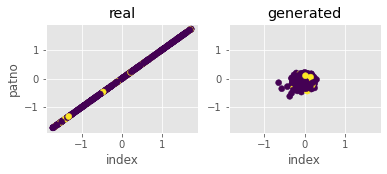

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 3.2109, 0.2064, 0.1419, 1.0000
D Real - D Gen: -0.0645


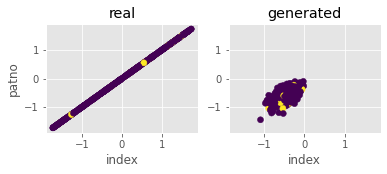

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 4.8038, 0.2423, 0.2790, 0.9979
D Real - D Gen: 0.0367


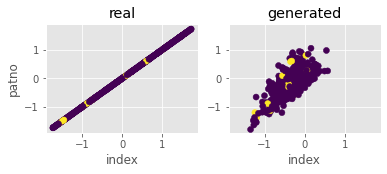

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 3.2999, 0.1543, 0.5660, 0.9979
D Real - D Gen: 0.4117


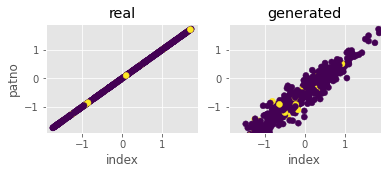

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 3.7153, 0.1522, 0.4430, 1.0000
D Real - D Gen: 0.2909


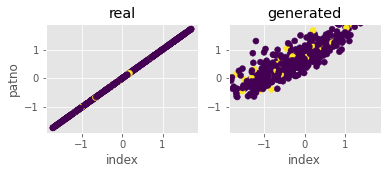

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 2.5120, 0.3850, 0.4223, 0.9872
D Real - D Gen: 0.0373


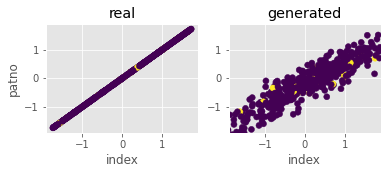

CPU times: user 1min 22s, sys: 4.62 s, total: 1min 27s
Wall time: 36.2 s


In [666]:
%%time
# CGAN
GAN.adversarial_training_GAN(
    arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
)

###### 6.2.3 WGAN and WCGAN <a class="anchor" id="wgan"></a>

In [604]:
# %%time
# # WGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
# )
# # WCGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
# )

#### 6.3 Loss Information <a class="anchor" id="loss"></a>

CPU times: user 504 ms, sys: 309 ms, total: 813 ms
Wall time: 919 ms


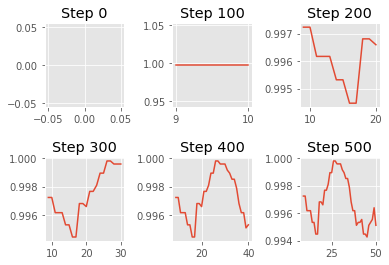

In [667]:
%%time
TYPE_ = 'CGAN'

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)
for i, step in zip(range(1, 7), range(0, 600, 100)):
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
        open('{}{}_losses_step_{}.pkl'.format(DIRECTORY, TYPE_, step), 'rb')
    )
    
    ax = fig.add_subplot(2, 3, i)
    ax.plot(pd.DataFrame(xgb_losses).rolling(10).mean())
    ax.title.set_text('Step {}'.format(step))

#### 6.4 Generate New Data <a class="anchor" id="new_data"></a>

In [668]:
DATA_DIM = len(data_cols)
LABEL_DIM = len(label_cols)
with_class = True if LABEL_DIM > 0 else False
np.random.seed(SEED)

In [669]:
generator, discriminator, combined = GAN.define_models_CGAN(
    RAND_DIM, DATA_DIM, LABEL_DIM, BASE_N_COUNT
)
generator.load_weights('GAN/outputs/CGAN_generator_model_weights_step_500.h5')

In [670]:
TEST_SIZE = len(train)
# TEST_SIZE = 7380

In [671]:
x = GAN.get_data_batch(train, TEST_SIZE, seed=SEED)
z = np.random.normal(size=(TEST_SIZE, RAND_DIM))
if with_class:
    labels = x[:, -LABEL_DIM:]
    g_z = generator.predict([z, labels])
else:
    g_z = generator.predict(z)

In [672]:
GAN.CheckAccuracy(
    x, g_z, data_cols, label_cols, seed=SEED, with_class=with_class, data_dim=DATA_DIM
)

0.9975609756097561

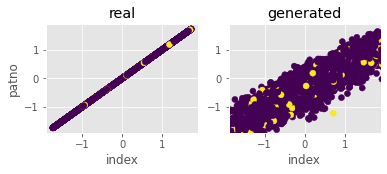

In [673]:
GAN.PlotData(
    x, g_z, data_cols, label_cols, seed=SEED, with_class=with_class, data_dim=DATA_DIM
)

#### 6.5 Test New Data on Models <a class="anchor" id="train_gan"></a>

In [674]:
real = pd.DataFrame(x, columns=data_cols+label_cols)
real['syn_label'] = 0
real.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,1.227691,1.227691,-0.509165,-0.881391,-0.141859,0.165960,0.313307,-0.118924,-0.254819,-0.760847,...,0.694442,0.611508,-0.077854,0.0,9.0,2.0,0.0,1.0,0.0,0
1,0.396400,0.396400,-0.381636,-0.173652,-0.044622,-0.122972,0.444810,-0.403647,-0.254819,-0.760847,...,0.724070,0.893380,0.119627,0.0,9.0,1.0,1.0,1.0,0.0,0
2,-0.795382,-0.795382,-1.231830,-0.964654,-0.239097,0.512679,0.444810,-0.118924,-0.254819,0.400433,...,0.842581,1.175251,0.909548,0.0,9.0,2.0,1.0,1.0,0.0,0
3,0.218971,0.218971,0.128479,1.449985,-0.628046,-0.816410,-0.344205,0.165799,-0.254819,-0.760847,...,0.783325,1.062503,0.119627,0.0,9.0,2.0,1.0,1.0,0.0,0
4,1.237548,1.237548,-2.039513,3.073621,-1.503183,-1.047556,0.181805,1.162329,-0.254819,-0.410332,...,-1.498025,-1.587089,-0.406988,0.0,9.0,1.0,0.0,1.0,0.0,0


In [675]:
test = pd.DataFrame(g_z, columns=data_cols+label_cols)
test['syn_label'] = 1
test.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,-0.240328,-0.267489,-0.827272,-1.081310,-0.405181,0.101475,0.380154,0.162481,0.043184,0.680507,...,0.714974,0.451016,0.535317,-0.305926,4.916377,2.026331,0.163135,-0.149925,0.0,1
1,1.159106,0.905948,0.093141,-0.979260,-0.236502,-0.194530,-0.206762,0.929320,-0.178177,0.236540,...,0.322282,0.542227,0.783689,0.115789,8.509847,1.777499,0.516916,0.665638,0.0,1
2,0.954823,-0.144053,0.386733,-0.876316,-0.829277,-0.175990,0.815680,0.693982,-0.231717,-0.415645,...,-1.732758,-1.111750,0.874151,0.211870,-2.040768,2.559062,0.185851,1.247087,0.0,1
3,0.193962,-0.377083,0.010430,-0.400110,-0.736992,0.131185,0.859832,0.045802,-0.184959,0.069155,...,-0.544641,0.153495,0.819202,0.034650,-1.785415,2.075395,0.202236,1.301209,0.0,1
4,-0.215777,-0.345091,0.073880,-1.395561,-0.081610,0.085673,0.222136,0.347401,0.018531,1.132054,...,-0.290608,-0.101480,0.258412,-0.136144,6.269863,1.515117,0.096457,-0.138680,0.0,1


In [676]:
SPLIT = 0.5

In [677]:
n_real, n_test = int(len(real)*SPLIT), int(len(test)*SPLIT)

In [685]:
train_gan = pd.concat([real[:n_real], test[:n_test]], axis=0)
train_gan = train_gan.sample(frac=1).reset_index(drop=True) # shuffle
test_gan = pd.concat([real[n_real:], test[n_test:]], axis=0)
test_gan = test_gan.sample(frac=1).reset_index(drop=True) # shuffle

In [679]:
X = train_gan.columns[:-2]
y = train_gan.columns[-1]
y_true = test_gan[y]
d_train = xgb.DMatrix(train_gan[X], train_gan[y], feature_names=X)
d_test = xgb.DMatrix(test_gan[X], feature_names=X)

In [680]:
parameters = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': SEED,
    'eval_metric': 'auc'
}
xgb_clf = xgb.train(parameters, d_train, num_boost_round=10)

**Metric Scores**

Accuracy: 99.76%
Precision: 99.95%
Recall: 99.57%
F1: 99.76%


**Confusion Matrix**

[[3674    2]
 [  16 3688]]


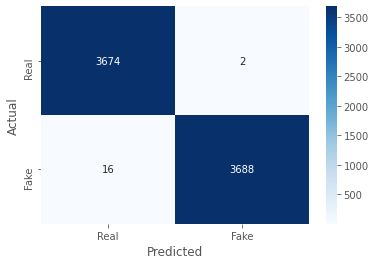

In [681]:
y_pred = np.round(xgb_clf.predict(d_test))
metric_evaluation(y_pred, y_true)
plot_confusion_matrix(y_pred, y_true, labels=['Real', 'Fake'])